---
## Feature extraction and DataFrame creation
---

### $\color{pink}{\text{(1) Some interesting notions}}$

- Reading audio files

In [110]:
#Importing some libraries

import librosa
import librosa.display
import IPython 
import numpy as np
import matplotlib.pyplot as plt


- Loading audio into python

In [111]:
audio_file = 'audio-dataset/cats_dogs/cat_1.wav'
x, sr = librosa.load(audio_file)

#IPython gives us a widget to play audio files through notebook.

IPython.display.display(IPython.display.Audio(audio_file))

- Visalizing Audio

The following visualization is called the $\color{violet}{\text{time-domain}}$ representation of a given signal. This shows us the amplitude of sound wave changing with time. Amplitude = 0 represents silence. 

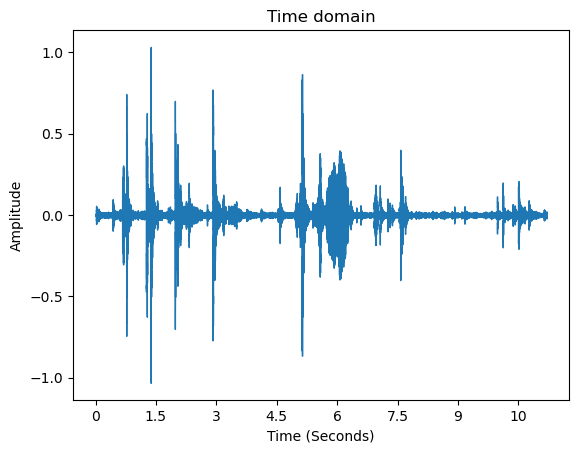

In [112]:
plt.figure()
librosa.display.waveshow(x,sr=sr)

plt.title("Time domain")
plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude")
plt.show()

These amplitudes are not very informative. To understand better the audio signal, it is necessary to transform it into the $\color{violet}{\text{frequency-domain}}$. The frequency-domain representation of a signal tells us what different frequencies are present in the signal. *Fourier Transform* is a mathematical concept that can convert a continuous signal from time-domain to frequency-domain. 

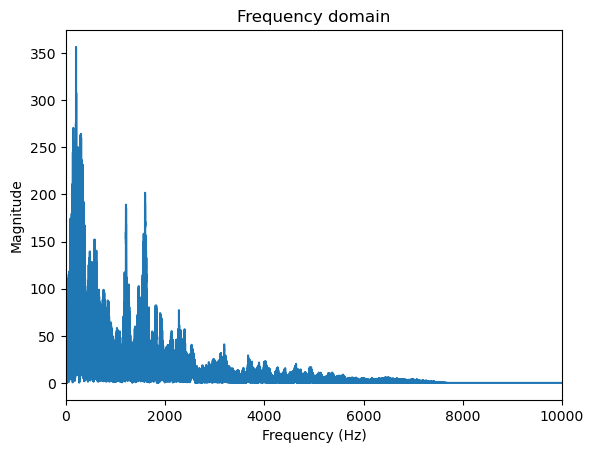

In [113]:
from scipy.fft import fft,fftshift
from scipy.fftpack import fft
from scipy.io import wavfile as wav

data_size = x.shape[0]
song_length_seconds = data_size/sr

freq_domain = np.linspace(-sr/2,sr/2,data_size)

# Fourier transform
fourier_data = abs(fft(x))
fourier_data_shift = fftshift(fourier_data)

plt.xlim([0,10000])
plt.title("Frequency domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.plot(freq_domain, fourier_data_shift)
plt.show()


$\color{violet}{\text{Spectograms}}$ are the visual representation of frequencies of a given signal with time. 

In the following plot, the **x-axis** represents **Time**, the **y-axis** represents **Frequency** and the colors represent magnitude (amplitude) of the observed frequency at a particular time. 

[Text(0.5, 1.0, 'Mel frequency spectrogram')]

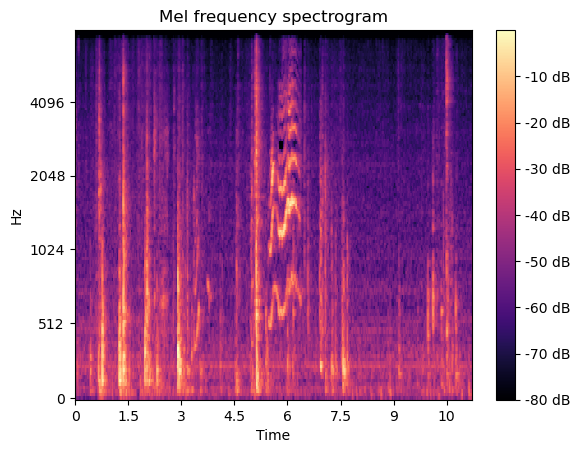

In [114]:
D = np.abs(librosa.stft(x))**2
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)

i = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)


fig.colorbar(i, ax=ax, format='%+2.0f dB')
ax.set(title='Mel frequency spectrogram')

### $\color{pink}{\text{(2) First steps}}$

In this notebook we will analyze one sample audio to extract features and then repeat it over all the dataset to create our feature-extracted dataset that we can work with.

First, we select a wav file and load it. As seen in the previous section, we get an array with all sample values **x** and the sampling frequency **sr**. 

In [115]:
audio_file = 'audio-dataset/cats_dogs/cat_100.wav'
x, sr = librosa.load(audio_file)
IPython.display.display(IPython.display.Audio(audio_file))
print("x ->",x)
print("sr ->",sr)

x -> [-0.0075894  -0.00924813 -0.00750379 ...  0.00456818  0.00502733
  0.        ]
sr -> 22050


We can convert our audio values into fourier space with the help of librosa, it automatically splits de audio on multiple overlapping "chunks" and computes the fft on it.

In [116]:
#on fourier domain, we are using a smaller window size becuase in documentation is recommended for speech processing
#this gives us much greater resolution
X = librosa.stft(x,n_fft=500)

#convert the signal into db scale
Xdb = librosa.amplitude_to_db(abs(X))
np.shape(Xdb)

(251, 229)

Just to have a look we can create a spectrograph of our audio, again withnthe help of librosa

Before, when we listened to the audio you can notice that there is a lot of noise. It would be interesting to find a way to detect when the cat is "meaowing" or a dog barking, and only use that part to extract a feature.


CREATING FREQUENCY BANDS
---

We will define some frequency bands that go from one to another frequency, the value of that band will be the mean of the amplitude of all the frequencies inside the range.

For now, we will make it linear but it might be interesting to try and create more bands in some frequencies range, for example around 3 kHz to increase sensitivity of these bands further in our classificator

In [117]:
#The output of librosa gives us when performing stft is 
#(251,1976) we could say that 251 is the frequencies where the amplitude has been measured
#we can get these frequencies given the window (n_fft) size
frequencies = librosa.fft_frequencies(sr=sr, n_fft=500)
print(len(frequencies))
frequencies

251


array([    0. ,    44.1,    88.2,   132.3,   176.4,   220.5,   264.6,
         308.7,   352.8,   396.9,   441. ,   485.1,   529.2,   573.3,
         617.4,   661.5,   705.6,   749.7,   793.8,   837.9,   882. ,
         926.1,   970.2,  1014.3,  1058.4,  1102.5,  1146.6,  1190.7,
        1234.8,  1278.9,  1323. ,  1367.1,  1411.2,  1455.3,  1499.4,
        1543.5,  1587.6,  1631.7,  1675.8,  1719.9,  1764. ,  1808.1,
        1852.2,  1896.3,  1940.4,  1984.5,  2028.6,  2072.7,  2116.8,
        2160.9,  2205. ,  2249.1,  2293.2,  2337.3,  2381.4,  2425.5,
        2469.6,  2513.7,  2557.8,  2601.9,  2646. ,  2690.1,  2734.2,
        2778.3,  2822.4,  2866.5,  2910.6,  2954.7,  2998.8,  3042.9,
        3087. ,  3131.1,  3175.2,  3219.3,  3263.4,  3307.5,  3351.6,
        3395.7,  3439.8,  3483.9,  3528. ,  3572.1,  3616.2,  3660.3,
        3704.4,  3748.5,  3792.6,  3836.7,  3880.8,  3924.9,  3969. ,
        4013.1,  4057.2,  4101.3,  4145.4,  4189.5,  4233.6,  4277.7,
        4321.8,  436

Note that the highest frequency that this gives us is 11025 Hz or 11kHz, this is due to the sampling frequency of our audio. Given that it is recorded at 22kHz due to the Nyquist–Shannon sampling theorem we know that the maximum frequency that it can record is the Nyquist-frequency. In this case 11025 Hz

This means that for these audios the higher frequency we can record is 11025Hz. So no data above that

We could now use these 251 frequencies measured as an input for our classifier. But we can take four other routes.

Now we can:
- 1-Use this on our classifiers as is:
- 2-Perform pca on it and try to let PCA decide what frequencies are more relevant.
- 3-Separate this into less frequency bands to reduce the amount of data
- 4-Perform pca on (3)
- 5-Separate this into frequency bands but give more space for certain frequency ranges that we think will be more relevant
- 6-Perform pca on (5)

Another option of analyzing our audio could be the following:

With librosa we can filter by chromas, which means setting a distance in frequency between two classes or "notes" and then detecting as same "note" or "class" frequencies that differ in one octave. So pitches instead of frequencies

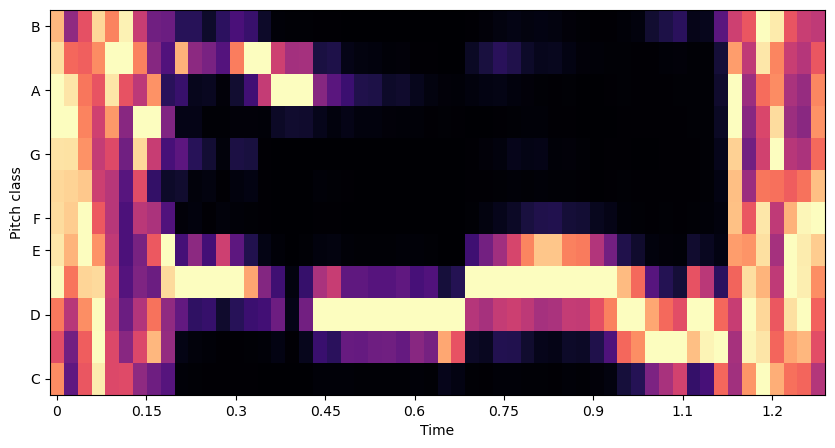

In [118]:
#Again we can get help of librosa 
chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr,n_chroma=12, n_fft=500)
plt.figure(figsize = (10, 5))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.show()

We can see that at time=6 when the cat meows there is an important change between the different frequency bands!

We will generate then 7 dataframes:

- 1-raw frequencies,as is:
- 2-Perform pca on raw
- 3-Separate this into less frequency bands to reduce the amount of data
- 4-Perform pca on (3)
- 5-Separate this into frequency bands but give more space for certain frequency ranges that we think will be more relevant
- 6-Perform pca on (5)
- 7-A number of chromas, using librosa library


CREATING THE DATAFRAMES
---

Before creating the dataframes, the first task we have to solve is to only have data from the parts where the can meows or the dog barks.

An idea would be to use the chroma pitch classes.

First idea, try looking where the count of pitch classes that are under the median is greater or over a threshold.

In [119]:
activation_count = np.array([0]*len(chroma_stft[0]))
thr = 0.5
median = [np.median(chroma_stft[i]) for i in range(len(chroma_stft))]
for i in range(len(chroma_stft[0])):
    for pitch in range(len(chroma_stft)):
        if(chroma_stft[pitch][i] <= median[pitch]*thr):
            activation_count[i] += 1

In [120]:
count_thr = 3
np.where(activation_count > count_thr)

(array([11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),)

These are the points once we did the chroma analysis where we detected something

Now we will get the slices where these points lie and piece them together in a new audio

In [121]:
#these are the points on chroma points
chroma_points = np.where(activation_count > count_thr)[0]

#lenght of chroma analysis audio
chr_len = len(chroma_stft[0])
#lenght of audio in samples x
x_len = len(x)

#so for every chroma point lies a number of x samples
phi = int(x_len / chr_len)

In [122]:
#to get our slices back we need a list of references
slices_ref = []
for ch_idx in chroma_points:
    #reference of center of slice in x points or "coordinates"
    x_idx = ch_idx * phi
    #to get the whole slice get half and half around center
    slices_ref.append([x_idx-int(phi/2),x_idx+int(phi/2)])

slices_ref

[[5345, 5853],
 [5854, 6362],
 [6872, 7380],
 [7381, 7889],
 [7890, 8398],
 [8399, 8907],
 [8908, 9416],
 [9417, 9925],
 [9926, 10434],
 [10435, 10943],
 [10944, 11452],
 [11453, 11961],
 [11962, 12470],
 [12471, 12979],
 [12980, 13488],
 [13489, 13997],
 [13998, 14506],
 [14507, 15015],
 [15016, 15524],
 [15525, 16033],
 [18070, 18578],
 [18579, 19087],
 [19088, 19596],
 [19597, 20105],
 [20106, 20614],
 [20615, 21123],
 [21124, 21632],
 [21633, 22141],
 [22142, 22650],
 [22651, 23159],
 [23160, 23668]]

Now we'll piece together the clean audio

In [123]:
x_cut = np.empty((1,0))
for slice in slices_ref:
    #to avoid indexing before 0
    #this could happend because of the way we generated the indexes
    slice_0 = slice[0]
    if slice_0 < 0 :
        slice_0 = 0
    slice_1 = slice[1]
    if slice_1 < 0:
        slice_1 = 0
    
    #print(type(x_cut))
    x_cut = np.append(x_cut,x[slice_0:slice_1])

Write cut audio back to file and reproduce

In [124]:
import soundfile as sf
sf.write('cut.wav', x_cut, sr, subtype='PCM_24')
IPython.display.display(IPython.display.Audio("cut.wav"))


If we compare it to our original audio is actually quite a good improvement

In [125]:
IPython.display.display(IPython.display.Audio(audio_file))

TO TEST MORE FILES GO TO THE FIRST CELL AND CHANGE THE audio_file VARIABLE TO ANY PATH :)

Now lets get the data for our dataframes:

Instead of getting x_cut and re-analyzing everything that data with a sample frequency, we think that the sharp audio-cuts can induce artifacts in the frequency analysis. This is why we will use the x analysis but use the indexes to make cuts to that instead.

In [126]:
# raw frequencies 
Xdb_len = len(Xdb[0]) #as is a matrix of (featuresx[samples])
phi = int(Xdb_len / chr_len)
#copy this code from before and modify it accordingly...

#to get our slices back we will directly append it to a new variable
Xdb_cut = [np.nan]*len(Xdb)
for ch_idx in chroma_points:
    #reference of center of slice in x points or "coordinates"
    Xdb_idx = ch_idx * phi
    #to get the whole slice get half and half around center, evade negative indexes
    slice_0 = Xdb_idx-int(phi/2)
    if slice_0 < 0 :
        slice_0 = 0
    slice_1 = Xdb_idx+int(phi/2)
    if slice_1 < 0:
        slice_1 = 0
    #slices_ref.append([freqraw_idx-int(phi/2),freqraw_idx+int(phi/2)])
    for a in range(len(Xdb)):
        Xdb_cut[a] = np.append(Xdb_cut[a],Xdb[a][slice_0:slice_1])


In [127]:
#for some reason the first value of each frequency isn't assigned and so is a nan
#we will just delete it
print("before: ",Xdb_cut[0][:5])

for a in range(len(Xdb)):
    Xdb_cut[a] =  Xdb_cut[a][1:]
print("after",Xdb_cut[0][:5])

before:  [         nan -11.19075203 -19.98746109 -14.03263569   1.16065729]
after [-11.19075203 -19.98746109 -14.03263569   1.16065729   7.95796299]


Now lets create some frequency bandss!

In [128]:
nbands = 25
nfreq = len(Xdb)
frequencies = librosa.fft_frequencies(sr=sr, n_fft=500)
Xdb_bnds = np.empty((nbands,len(Xdb_cut[0])))

lamb = int(nfreq/(nbands))
#iterate all bands we wanna create
for band in range(nbands):
    #iterate all data points, for each calculate the mean over all frequencies inside the band
    cut1 = band*lamb
    cut2 = band*lamb+lamb 
    print("cut1: ",cut1)
    print("cut2: ",cut2)
    for data_idx in range(len(Xdb_cut[0])):
        values = []
        #retrieve points for the mean
        
        for freq in range(cut1,cut2):
            values.append(Xdb_cut[freq][data_idx])
        
        #compute mean and append to that band
        Xdb_bnds[band][data_idx] = np.max(values)
    print("")

cut1:  0
cut2:  10

cut1:  10
cut2:  20

cut1:  20
cut2:  30

cut1:  30
cut2:  40

cut1:  40
cut2:  50

cut1:  50
cut2:  60

cut1:  60
cut2:  70

cut1:  70
cut2:  80

cut1:  80
cut2:  90

cut1:  90
cut2:  100

cut1:  100
cut2:  110

cut1:  110
cut2:  120

cut1:  120
cut2:  130

cut1:  130
cut2:  140

cut1:  140
cut2:  150

cut1:  150
cut2:  160

cut1:  160
cut2:  170

cut1:  170
cut2:  180

cut1:  180
cut2:  190

cut1:  190
cut2:  200

cut1:  200
cut2:  210

cut1:  210
cut2:  220

cut1:  220
cut2:  230

cut1:  230
cut2:  240

cut1:  240
cut2:  250



Like this it doesn't exactly go up to 240 due to that the division of n_freq=251/n_bands=20 is not even. To get up to the last higher frequencies we separate up to n_bands-1 and then the last band is whatever is left up to the frequency 251

Doing it in this even frequencies band would create a high frequencies band more sensitive to the classifier? maybe better not do that?

Let's leave it as is, just changed the number of output bands so there are less original frequencies left out

In [129]:
#check the shape to see that everythign worked allright
np.shape(Xdb_bnds)

(25, 124)

In [130]:
#compare with Xdb
np.shape(Xdb_cut)

(251, 124)

Now lets create more bands but give more importance to the higher frequencies, meaning that bands will be wider on the lower frequencies and shorter in the higher 

We'll use the same code but run the indexing of frequencies through a logarithmic function.

In [131]:
import math

In [132]:
#our function defined at 0
#function = 1 at x=1
def function(x):
    y = -(x-1)**2 + 1
    return y

In [133]:
nfreq = len(Xdb)
frequencies = librosa.fft_frequencies(sr=sr, n_fft=500)
Xdb_bnds = np.empty((nbands,len(Xdb_cut[0])))

lamb = int(nfreq/nbands)
#iterate all bands we wanna create
for band in range(nbands):
    #iterate all data points, for each calculate the mean over all frequencies inside the band
    for data_idx in range(len(Xdb_cut[0])):
        values = []
        #retrieve points for the mean

        #run indexes through a log function to make it non linear
        #scale values to fit well log function divide by
        scalar1 = function(band/nbands)
        freq1 = int(scalar1*lamb*nbands)
        scalar2 = function((band + 1)/nbands)
        freq2 = int(scalar2*lamb*nbands)

        for freq in range(freq1,freq2):
            values.append(Xdb_cut[freq][data_idx])
        #compute mean and append to that band
        Xdb_bnds[band][data_idx] = np.max(values)
    #print for debugging purposes
    print("band: ",band)
    print("scalar1: ",function((band/nbands)))
    print("freq1: ",freq1)
    print("scalar2: ",function((band + 1)/nbands))
    print("freq2: ",freq2)
    print("nfreq_bnd: ",freq2-freq1)
    print("")


band:  0
scalar1:  0.0
freq1:  0
scalar2:  0.07840000000000003
freq2:  19
nfreq_bnd:  19

band:  1
scalar1:  0.07840000000000003
freq1:  19
scalar2:  0.15359999999999996
freq2:  38
nfreq_bnd:  19

band:  2
scalar1:  0.15359999999999996
freq1:  38
scalar2:  0.22560000000000002
freq2:  56
nfreq_bnd:  18

band:  3
scalar1:  0.22560000000000002
freq1:  56
scalar2:  0.2944000000000001
freq2:  73
nfreq_bnd:  17

band:  4
scalar1:  0.2944000000000001
freq1:  73
scalar2:  0.3599999999999999
freq2:  89
nfreq_bnd:  16

band:  5
scalar1:  0.3599999999999999
freq1:  89
scalar2:  0.4224
freq2:  105
nfreq_bnd:  16

band:  6
scalar1:  0.4224
freq1:  105
scalar2:  0.48160000000000003
freq2:  120
nfreq_bnd:  15

band:  7
scalar1:  0.48160000000000003
freq1:  120
scalar2:  0.5376000000000001
freq2:  134
nfreq_bnd:  14

band:  8
scalar1:  0.5376000000000001
freq1:  134
scalar2:  0.5904
freq2:  147
nfreq_bnd:  13

band:  9
scalar1:  0.5904
freq1:  147
scalar2:  0.64
freq2:  160
nfreq_bnd:  13

band:  10
s

PERFORMING THIS FOR ALL AUDIOS AND CREATING DATAFRAMES
---

In [134]:
import pandas as pd
import glob #for getting all file names

We first create a base dataframe from which all other 7 will be crreated

In [135]:
list_of_files = glob.glob("audio-dataset/cats_dogs/*.wav")
df_base = pd.DataFrame(columns = ["file","animal"])
df_base["file"]= list_of_files
df_base = df_base.set_index('file')
df_base

,animal
file,
audio-dataset/cats_dogs/cat_74.wav,NaN
audio-dataset/cats_dogs/dog_barking_63.wav,NaN
audio-dataset/cats_dogs/cat_60.wav,NaN
audio-dataset/cats_dogs/dog_barking_77.wav,NaN
audio-dataset/cats_dogs/cat_48.wav,NaN
...,...
audio-dataset/cats_dogs/cat_45.wav,NaN
audio-dataset/cats_dogs/dog_barking_46.wav,NaN
audio-dataset/cats_dogs/cat_51.wav,NaN


Get the animal class for the file

In [136]:
for i in range(len(df_base.index)):
    if "dog_" in df_base.index[i]:
        df_base.at[df_base.index[i],"animal"] = 0
    if "cat_" in df_base.index[i]:
        df_base.at[df_base.index[i],"animal"] = 1
df_base

,animal
file,
audio-dataset/cats_dogs/cat_74.wav,1
audio-dataset/cats_dogs/dog_barking_63.wav,0
audio-dataset/cats_dogs/cat_60.wav,1
audio-dataset/cats_dogs/dog_barking_77.wav,0
audio-dataset/cats_dogs/cat_48.wav,1
...,...
audio-dataset/cats_dogs/cat_45.wav,1
audio-dataset/cats_dogs/dog_barking_46.wav,0
audio-dataset/cats_dogs/cat_51.wav,1


Now we can create all our dataframes, pca ones won't be created now becuase they can be created from the ones without applying pca

In [137]:
df_raw = df_base.copy()
df_bands = df_base.copy()
df_bands_nolin = df_base.copy()
df_pitches = df_base.copy()

For each dataframe create their columns

In [138]:
#pitch df
for i in range(len(chroma_stft)):
    df_pitches['chroma_'+str(i)] = np.nan

#raw df
for i in range(len(Xdb_cut)):
    df_raw['freq'+str(i)] = np.nan

#bands lin
for i in range(len(Xdb_bnds)):
    df_bands['band'+str(i)] = np.nan
    df_bands_nolin['band'+str(i)] = np.nan


/var/folders/j8/64lnvrmj50q5dv_5dj_ztbz40000gn/T/ipykernel_89608/1541156920.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_raw['freq'+str(i)] = np.nan
/var/folders/j8/64lnvrmj50q5dv_5dj_ztbz40000gn/T/ipykernel_89608/1541156920.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_raw['freq'+str(i)] = np.nan
/var/folders/j8/64lnvrmj50q5dv_5dj_ztbz40000gn/T/ipykernel_89608/1541156920.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

Now iterate over all files and add the data to the dataframes

In [139]:
#defined this function to be able to change if we wanted to use mean, max, min
#or whatever when merging all time-values into a single scalar for that file 
def feature_calc(time_feat):
    return np.mean(time_feat)

In [140]:
for file in df_base.index:
    #load file
    x, sr = librosa.load(file)

    #first step, get the parts where the animal is making sound
    #get the pitch data
    chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr,n_chroma=12, n_fft=500)
    X = librosa.stft(x,n_fft=500)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    #get the activation counts
    activation_count = np.array([0]*len(chroma_stft[0]))
    thr = 0.5
    median = [np.median(chroma_stft[i]) for i in range(len(chroma_stft))]
    for i in range(len(chroma_stft[0])):
        for pitch in range(len(chroma_stft)):
            if(chroma_stft[pitch][i] <= median[pitch]*thr):
                activation_count[i] += 1

    count_thr=3
    #these are the points on chroma points where the count is over threshold
    chroma_points = np.where(activation_count > count_thr)[0]
    #lenght of chroma analysis audio
    chr_len = len(chroma_stft[0])


    #-----
    #Now that we have our cut references we can start by getting data for each df
    #------
    #CHROMA PITCH FF
    #let's start with what we already have cut
    for i in range(len(chroma_stft)):
        #for each chroma add points selected by activation
        df_pitches.loc[file,'chroma_'+str(i)] = feature_calc(chroma_stft[i][chroma_points])
    
    # RAW FREQ DF
    Xdb_len = len(Xdb[0]) #as is a matrix of (featuresx[samples])
    phi = int(Xdb_len / chr_len)

    #to get our slices back we will directly append it to a new variable
    Xdb_cut = [np.nan]*len(Xdb)
    for ch_idx in chroma_points:
        #reference of center of slice in x points or "coordinates"
        Xdb_idx = ch_idx * phi
        #to get the whole slice get half and half around center, evade negative indexes
        slice_0 = Xdb_idx-int(phi/2)
        if slice_0 < 0 :
            slice_0 = 0
        slice_1 = Xdb_idx+int(phi/2)
        if slice_1 < 0:
            slice_1 = 0
        #slices_ref.append([freqraw_idx-int(phi/2),freqraw_idx+int(phi/2)])
        for a in range(len(Xdb)):
            Xdb_cut[a] = np.append(Xdb_cut[a],Xdb[a][slice_0:slice_1])

    for i in range(len(Xdb_cut)):
        #for each chroma add points selected by activation
        #[1:] to avoid the first nan (little trick)
        df_raw.loc[file,'freq'+str(i)] = feature_calc(Xdb_cut[i][1:])
    
    #FREQ BANDS LINEAR DF
    nbands = 25
    nfreq = len(Xdb)
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=500)
    Xdb_bnds = np.empty((nbands,len(Xdb_cut[0])))

    lamb = int(nfreq/(nbands))
    #iterate all bands we wanna create
    for band in range(nbands):
        #iterate all data points, for each calculate the mean over all frequencies inside the band
        cut1 = band*lamb
        cut2 = band*lamb+lamb 
        for data_idx in range(len(Xdb_cut[0])):
            values = []
            #retrieve points for the mean
            
            for freq in range(cut1,cut2):
                values.append(Xdb_cut[freq][data_idx])
            
            #compute mean and append to that band
            Xdb_bnds[band][data_idx] = np.mean(values)
    
    for i in range(len(Xdb_bnds)):
        #for each chroma add points selected by activation
        #[1:] to avoid the first nan (little trick)
        df_bands.loc[file,'band'+str(i)] = feature_calc(Xdb_bnds[i][1:])
    
    #FREQ BANDS NON-LINEAR DF
    #commented because already calculated before
    #nfreq = len(Xdb)
    #frequencies = librosa.fft_frequencies(sr=sr, n_fft=500)
    Xdb_bnds = np.empty((nbands,len(Xdb_cut[0])))

    lamb = int(nfreq/nbands)
    #iterate all bands we wanna create
    for band in range(nbands):
        #iterate all data points, for each calculate the mean over all frequencies inside the band
        for data_idx in range(len(Xdb_cut[0])):
            values = []
            #retrieve points for the mean

            #run indexes through a log function to make it non linear
            #scale values to fit well log function divide by
            scalar1 = function(band/nbands)
            freq1 = int(scalar1*lamb*nbands)
            scalar2 = function((band + 1)/nbands)
            freq2 = int(scalar2*lamb*nbands)

            for freq in range(freq1,freq2):
                values.append(Xdb_cut[freq][data_idx])
            #compute mean and append to that band
            Xdb_bnds[band][data_idx] = np.mean(values)
    
    for i in range(len(Xdb_bnds)):
        #for each chroma add points selected by activation
        #[1:] to avoid the first nan (little trick)
        df_bands_nolin.loc[file,'band'+str(i)] = feature_calc(Xdb_bnds[i][1:])

Fianlly write these df to file for further use

In [141]:
#finally write all dataframes to files
df_raw.to_csv("dataframes/freq_raw.csv")
df_bands.to_csv("dataframes/bands_lin.csv")
df_bands_nolin.to_csv("dataframes/bands_nolin.csv")
df_pitches.to_csv("dataframes/tonal_pitches.csv")